## Import

In [44]:
from ipywidgets import *
from scipy.stats import pearsonr, ttest_rel
from sklearn.metrics import jaccard_score
from sklearn.decomposition import PCA
import numpy as np
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import pickle
from scipy.ndimage import gaussian_filter1d
warnings.filterwarnings(action='ignore')

np.set_printoptions(suppress=True)

mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['axes.spines.top'] = True
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.left'] = True

def cos_sim(A, B):
    return np.dot(A, B)/(np.linalg.norm(A)*np.linalg.norm(B))

In [16]:
movie_event_idx = np.load('/home/dasom/State_dynamics/results/exclude_short_movie.npy')

overlap_start = np.load('/home/dasom/State_dynamics/results/movie_event_start_idx.npy')
overlap_end = np.load('/home/dasom/State_dynamics/results/movie_event_boundary_idx.npy') # event boundary

event_start_tot = np.load('/home/dasom/State_dynamics/results/Recall_event_onset.npy', allow_pickle=True) # recall start
event_end_tot = np.load('/home/dasom/State_dynamics/results/Recall_event_offset.npy', allow_pickle=True) # recall end
event_idx = np.load('/home/dasom/State_dynamics/results/Recall_event_idx.npy', allow_pickle=True) # recalled event index of each participant

rest_tr_ep1 = np.load('/home/dasom/State_dynamics/results/rest_tr_ep1.npy')
rest_tr_ep2 = np.load('/home/dasom/State_dynamics/results/rest_tr_ep2.npy')
rest_tr_ep3 = np.load('/home/dasom/State_dynamics/results/rest_tr_ep3.npy')

rest_total = rest_tr_ep1.shape[0] + rest_tr_ep2.shape[0] + rest_tr_ep3.shape[0]
rest_tr = np.hstack([rest_tr_ep1, rest_tr_ep2+996, rest_tr_ep3+996+958])

## Novelty and Memorability measurements

#### Memorability

In [25]:
Memorability_score_total = np.load('/home/dasom/State_dynamics/results/Memorability_score_total.npy')
Memorability_score = np.load('/home/dasom/State_dynamics/results/Memorability_score.npy')
Memorability_score_numbers = Memorability_score.copy()
Memorability_score_numbers[Memorability_score_numbers > 0] = 1
memorability = np.mean(Memorability_score, axis=0)

recall_sim = np.zeros((24,24))
for s1 in range(24):
    for s2 in range(24):
        recall_sim[s1,s2] = jaccard_score(Memorability_score_numbers[s1],Memorability_score_numbers[s2])

In [55]:
print('Mean ratio of recalled events (total): ', np.mean(Memorability_score > 0))

Mean ratio of recalled events (total):  0.7606589147286822


In [54]:
print('Mean memorability score: ', np.mean(Memorability_score))
print('SD memorability score: ', np.std(np.mean(Memorability_score, axis=0)))

Mean memorability score:  0.22771888346898392
SD memorability score:  0.08406357643419936


In [49]:
print('Mean Jaccard score: ', np.mean(recall_sim[np.triu_indices(24,1)]))

Mean Jaccard score:  0.7153542804467719


([], [])

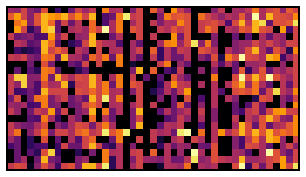

In [56]:
## Supp Fig.1A, 1B
plt.figure(figsize = [6,3])
plt.imshow(Memorability_score, cmap = 'inferno', vmin = 0, vmax = 0.6) # Memorability_score_numbers
plt.xticks([])
plt.yticks([])
# plt.savefig('/home/dasom/Dropbox/ubuntu-window/미팅자료/Neural_dynamics/Memory_novelty_cooccur_valence/Recall_performance.png', dpi=300, bbox_inches = "tight")

#### Novelty

In [5]:
cooccur_sim = np.load('/home/dasom/State_dynamics/results/cooccur_similarity.npy')

nove_cooccur_1 = np.where(cooccur_sim >= np.percentile(cooccur_sim,200/3))[0]
nove_cooccur_2 = np.where((cooccur_sim >= np.percentile(cooccur_sim,100/3)) & (cooccur_sim < np.percentile(cooccur_sim,200/3)))[0]
nove_cooccur_3 = np.where(cooccur_sim < np.percentile(cooccur_sim,100/3))[0]

valence_sim = np.load('/home/dasom/State_dynamics/results/valence_similarity.npy')

nove_valence_1 = np.where(valence_sim >= np.percentile(valence_sim,200/3))[0]
nove_valence_2 = np.where((valence_sim >= np.percentile(valence_sim,100/3)) & (valence_sim < np.percentile(valence_sim,200/3)))[0]
nove_valence_3 = np.where(valence_sim < np.percentile(valence_sim,100/3))[0]

#### Relationship betwee time and novelties (Supp Fig. 1C)

PearsonRResult(statistic=0.04896992415317076, pvalue=0.7551605813134374)


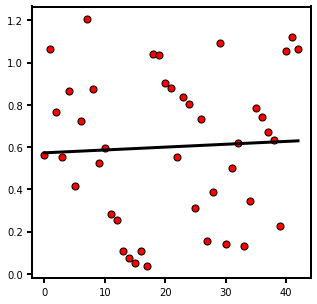

In [258]:
plt.figure(figsize = [5,5])
x = np.arange(43)
y = 1-cooccur_sim
plt.scatter(x, y, s = 50, color = 'red', edgecolor = 'k')
a, b = np.polyfit(x, y, deg=1)
y_est = a * x + b
plt.plot(x, y_est, '-', color = 'black', linewidth = 3)
print(pearsonr(x, y))
# plt.savefig('/home/dasom/Dropbox/ubuntu-window/미팅자료/Neural_dynamics/Memory_novelty_cooccur_valence/Valence_time.png', dpi=300, bbox_inches = "tight")

#### Relationship between novelties (Fig. 2D)

PearsonRResult(statistic=0.17467634649819092, pvalue=0.26257888657253536)


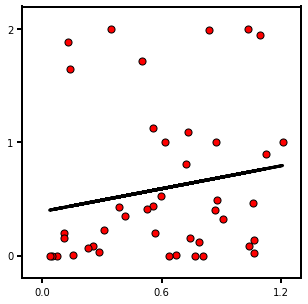

In [256]:
x = 1-cooccur_sim
y = 1-valence_sim
a, b = np.polyfit(x, y, deg=1)
y_est = a * x + b
y_err = x.std() * np.sqrt(1/len(x) + x**2 / np.sum(x**2))

fig, ax = plt.subplots(figsize = [5,5])
ax.plot(x, y_est, '-', color = 'black', linewidth = 3)
# ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2, color = 'grey')
ax.scatter(x, y, s = 50, color='red', edgecolor = 'black')

plt.xlim([-0.1,1.3])
plt.ylim([-0.2,2.2])
plt.xticks([0,0.6,1.2])
plt.yticks([0,1,2])
print(pearsonr(x, y))
# plt.savefig('/home/dasom/Dropbox/ubuntu-window/미팅자료/Neural_dynamics/Memory_novelty_cooccur_valence/Relationship_btw_cooccur_valence2.png', dpi=300, bbox_inches = "tight")

#### Relationship between novelty and memorability (Fig. 2F)

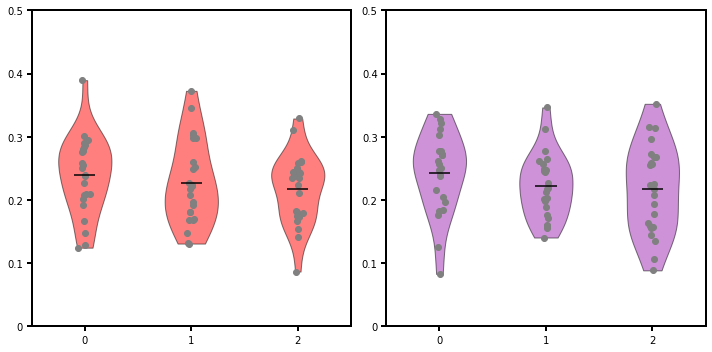

In [259]:
np.random.seed(2023)
fig = plt.figure(figsize = [10,5])
axs = fig.add_subplot(1,2,1)
subj_memory = np.array([np.mean(Memorability_score[:,i], axis=1) for i in [nove_cooccur_1, nove_cooccur_2, nove_cooccur_3]])
violin_parts = axs.violinplot(subj_memory.T, np.arange(3), showmeans=False, showmedians=False, showextrema=False, widths = 0.5)
for vp in violin_parts['bodies']:
    vp.set_facecolor('#FF0000')  # aa0000 FF00FF 00FFFF
    vp.set_edgecolor('#000000')
    vp.set_alpha(0.5)

for c in range(3):
    plt.scatter(np.random.normal(loc = c, scale = 0.02, size = 24), subj_memory[c], color = 'grey')
    plt.hlines(np.mean(subj_memory[c]), c-0.1, c+0.1, zorder = 1, color = 'k')

axs.set_xticks([0,1,2])
axs.set_yticks([0,0.1,0.2,0.3,0.4,0.5])
axs.set_yticklabels([0,0.1,0.2,0.3,0.4,0.5])
axs.set_xlim([-0.5,2.5])
axs.set_ylim([0, 0.5])

axs = fig.add_subplot(1,2,2)
subj_memory = np.array([np.mean(Memorability_score[:,i], axis=1) for i in [nove_valence_1, nove_valence_2, nove_valence_3]])
violin_parts = axs.violinplot(subj_memory.T, np.arange(3), showmeans=False, showmedians=False, showextrema=False, widths = 0.5)
for vp in violin_parts['bodies']:
    vp.set_facecolor('#9C27B0')  # aa0000 FF00FF 00FFFF
    vp.set_edgecolor('#000000')
    vp.set_alpha(0.5)

for c in range(3):
    plt.scatter(np.random.normal(loc = c, scale = 0.02, size = 24), subj_memory[c], color = 'grey')
    plt.hlines(np.mean(subj_memory[c]), c-0.1, c+0.1, zorder = 1, color = 'k')

axs.set_xticks([0,1,2])
axs.set_yticks([0,0.1,0.2,0.3,0.4,0.5])
axs.set_yticklabels([0,0.1,0.2,0.3,0.4,0.5])
axs.set_xlim([-0.5,2.5])
axs.set_ylim([0, 0.5])
fig.tight_layout()
# fig.savefig('/home/dasom/Dropbox/ubuntu-window/미팅자료/Neural_dynamics/Memory_novelty_cooccur_valence/Relationship_btw_novelty_memory.png', dpi=300, bbox_inches = "tight")

In [57]:
score_mean_cooccur = np.array([np.mean(Memorability_score[:,i], axis=1) for i in [nove_cooccur_1, nove_cooccur_3]])
score_mean_valence = np.array([np.mean(Memorability_score[:,i], axis=1) for i in [nove_valence_1, nove_valence_3]])

print(ttest_rel(score_mean_cooccur[0], score_mean_cooccur[1]))
print(ttest_rel(score_mean_valence[0], score_mean_valence[1]))

Ttest_relResult(statistic=2.1795486707118896, pvalue=0.03978463654769748)
Ttest_relResult(statistic=2.2644236766967767, pvalue=0.033284260908745304)


## Brain data

In [8]:
with open('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/SM_DATA/social_movie1/results/fMRI_data/movie_data_ex2_sc_sm.pickle', 'rb') as f:
    movie_data = pickle.load(f)
    
with open('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/SM_DATA/social_movie1/results/fMRI_data/recall_data_ex2_sc_sm.pickle', 'rb') as f:
    recall_data_concat = pickle.load(f)

brain_mask = nib.load(f'/home/dasom/SM_DATA/mri_data/mask_files/MNI152NLin2009cAsym_3mm_mask.nii.gz').get_fdata()
mask = nib.load('/home/dasom/SM_DATA/mri_data/mask_files/BNA_3mm_atlas.nii.gz').get_fdata()

In [261]:
# movie viewing
window_length = 21

roi_mask1 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [215,216,217,218]]) # HIPP
roi_mask2 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [111,112,119,120]]) # PHC
roi_mask3 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [115,116]]) # EC
roi_mask4 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [117,118]]) # PRC
roi_mask5 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [75,76,79,80]]) # STG
roi_mask6 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [87,88,121,122]]) # STS
roi_mask7 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [143,144]]) # TPJ
roi_mask8 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [153,154,175,176]]) # PMC
roi_mask9 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [13,14]]) # DMPFC
roi_mask10 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [41,42]]) # VMPFC
roi_mask11 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [189,190,191,192,193,194]]) # VC
roi_mask12 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [71,72]]) # AC
roi_mask13 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [179,187,188]]) # ACC

patterns = []
# for rm in [roi_mask1,roi_mask2,roi_mask3,roi_mask4,roi_mask5,roi_mask6,roi_mask7,roi_mask8,roi_mask9,roi_mask10,roi_mask11,roi_mask12,roi_mask13]:
for rm in [roi_mask1]:
    pattern = []
    for s in range(movie_data.shape[0]):
        movie_data_sub = movie_data[s, rm]
        # movie_data_sub = gaussian_filter1d(movie_data[s, rm], sigma = 3, axis = -1) # For visualization
        ev_pattern = []
        for ev in overlap_end[movie_event_idx[1:]]:
            ev_pattern.append(movie_data_sub[:,ev-6:ev+15])
        pattern.append(ev_pattern)
    patterns.append(np.array(pattern))

In [ ]:
# narrative recall
window_length = 21 # 18 for end
roi_mask1 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [215,216,217,218]]) # HIPP

patterns_recall = []
for rm in [roi_mask1]:
    pattern = []
    for s in range(len(recall_data_concat)):
        recall_data_sub = recall_data_concat[s][rm]
        ev_pattern = []
        for ev in event_start_tot[s]:
            ev_pattern.append(recall_data_sub[:,ev-6:ev+15])
        pattern.append(np.array(ev_pattern))
    patterns_recall.append(pattern)
    # patterns.append(gaussian_filter1d(pattern, sigma = 3, axis = -1, mode = 'nearest')) # For visualization

#### Canonical space

In [20]:
roi_mask1 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [215,216,217,218]]) # hippocampus
pca_canonical = PCA(n_components=20)
data = np.hstack([np.hstack([movie_data[s,roi_mask1][:,rest_tr],recall_data_concat[s][roi_mask1]]) for s in range(24)]) # concatenate movie and recall neural data
data_hipp_canonical = pca_canonical.fit(data.T)
np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/hipp_canonical_component.npy', data_hipp_canonical.components_)

print(data_hipp_canonical.explained_variance_ratio_)

[0.07025423 0.0291544  0.02096409 0.02027759 0.018777   0.01749794
 0.01673815 0.01593772 0.0151947  0.01440846 0.01406822 0.01361847
 0.01311901 0.01236906 0.0119873  0.0118558  0.0117423  0.01087593
 0.01067101 0.01057868]


## Extracting subspaces

### Linear regression

#### Novelty & Memory

In [153]:
which_cognition = 'novelty' # novelty / memory

np.random.seed(2023)

repetition = 1000
beta_true = []
beta_perm = []
for data_pattern in patterns:
    beta_tot_true = []
    beta_tot_perm = []
    for repeat in range(repetition + 1):
        if repeat == 0:
            if which_cognition == 'novelty':
                conds = np.array([np.intersect1d(nove_cooccur_1, nove_valence_1), np.intersect1d(nove_cooccur_1, nove_valence_2), np.intersect1d(nove_cooccur_1, nove_valence_3),
                                  np.intersect1d(nove_cooccur_2, nove_valence_1), np.intersect1d(nove_cooccur_2, nove_valence_2), np.intersect1d(nove_cooccur_2, nove_valence_3),
                                  np.intersect1d(nove_cooccur_3, nove_valence_1), np.intersect1d(nove_cooccur_3, nove_valence_2), np.intersect1d(nove_cooccur_3, nove_valence_3)])
            elif which_cognition == 'memory':
                conds = np.array_split(np.argsort(-memorability), 9) # from low to high
            
            conds_regressor = []
            for cd in conds:
                cr = np.zeros(43)
                cr[cd] = 1
                conds_regressor.append(cr)

            FIR_tot = []
            for s in range(movie_data.shape[0]):
                F = np.array([conds_regressor[cr] for cr in range(len(conds_regressor))])
                beta = []
                for t in range(window_length):
                    beta.append(np.dot(np.dot(np.linalg.inv(np.dot(F, F.T)), F), data_pattern[s][:,:,t]))
                FIR_tot.append(beta)
            FIR_tot = np.array(FIR_tot)

            for s in range(movie_data.shape[0]):
                if which_cognition == 'novelty':
                    F = np.array([[-1,-1,-1,0,0,0,1,1,1],
                                  [-1,0,1,-1,0,1,-1,0,1],
                                  [1,1,1,1,1,1,1,1,1]]) 
                elif which_cognition == 'memory':   
                    F = np.array([[np.mean(memorability[ev]) - np.mean(memorability) for ev in conds],
                                  [1,1,1,1,1,1,1,1,1]])             
                beta = []
                for t in range(window_length):
                    beta.append(np.dot(np.dot(np.linalg.inv(np.dot(F, F.T)), F), FIR_tot[s][t]))
                beta_tot_true.append(beta)    

        else:
            conds_regressor = []
            for cd in conds:
                cr = np.zeros(43)
                cr[cd] = 1
                conds_regressor.append(cr)

            FIR_tot = []
            for s in range(movie_data.shape[0]):
                F = np.array([conds_regressor[cr] for cr in range(len(conds_regressor))])
                beta = []
                for t in range(window_length):
                    beta.append(np.dot(np.dot(np.linalg.inv(np.dot(F, F.T)), F), data_pattern[s][:,:,t]))
                FIR_tot.append(beta)
            FIR_tot = np.array(FIR_tot)

            betas = []
            for s in range(movie_data.shape[0]):
                if which_cognition == 'novelty':
                    F = np.array([[-1,-1,-1,0,0,0,1,1,1],
                                  [-1,0,1,-1,0,1,-1,0,1],
                                  [1,1,1,1,1,1,1,1,1]]) 
                elif which_cognition == 'memory':
                    F = np.array([[np.mean(memorability[ev]) - np.mean(memorability) for ev in conds],
                                  [1,1,1,1,1,1,1,1,1]])                          
                np.random.shuffle(F.T)
                beta = []
                for t in range(window_length):
                    beta.append(np.dot(np.dot(np.linalg.inv(np.dot(F, F.T)), F), FIR_tot[s][t]))
                betas.append(beta)
            beta_tot_perm.append(betas)
    beta_true.append(np.array(beta_tot_true))
    beta_perm.append(np.array(beta_tot_perm))

if which_cognition == 'novelty':
    beta_true_novelty = beta_true
    beta_perm_novelty = beta_perm
    print('novelty beta matrix')
    
elif which_cognition == 'memory':
    beta_true_memory = beta_true
    beta_perm_memory = beta_perm
    print('memory beta matrix')

novelty beta matrix


#### Retrieval

In [216]:
np.random.seed(2023)

repetition = 100
beta_true_recall = []
beta_perm_recall = []
for data_pattern in patterns_recall:
    beta_tot_true = []
    beta_tot_perm = []
    for repeat in range(repetition + 1):
        if repeat == 0:
            for s in range(movie_data.shape[0]):

                score_sub = Memorability_score_total[s][event_idx[s]]
                recall_task6 = np.where(score_sub >= np.percentile(score_sub, 500/6))[0]
                recall_task5 = np.where((score_sub >= np.percentile(score_sub, 400/6)) & (score_sub < np.percentile(score_sub, 500/6)))[0]
                recall_task4 = np.where((score_sub >= np.percentile(score_sub, 300/6)) & (score_sub < np.percentile(score_sub, 400/6)))[0]
                recall_task3 = np.where((score_sub >= np.percentile(score_sub, 200/6)) & (score_sub < np.percentile(score_sub, 300/6)))[0]
                recall_task2 = np.where((score_sub >= np.percentile(score_sub, 100/6)) & (score_sub < np.percentile(score_sub, 200/6)))[0]
                recall_task1 = np.where(score_sub < np.percentile(score_sub, 100/6))[0]

                conds = np.array([recall_task6, recall_task5, recall_task4, recall_task3, recall_task2, recall_task1])
                
                conds_regressor = []
                for cd in conds:
                    cr = np.zeros(len(score_sub))
                    cr[cd] = 1
                    conds_regressor.append(cr)
                    
                F = np.array([conds_regressor[cr] for cr in range(len(conds_regressor))])
                FIR_tot = []
                for t in range(window_length):
                    FIR_tot.append(np.dot(np.dot(np.linalg.inv(np.dot(F, F.T)), F), data_pattern[s][:,:,t]))
                FIR_tot = np.array(FIR_tot)

                F = np.array([[np.mean(score_sub[ev]) - np.mean(score_sub) for ev in conds],
                              [1,1,1,1,1,1]])                
                beta = []
                for t in range(window_length):
                    beta.append(np.dot(np.dot(np.linalg.inv(np.dot(F, F.T)), F), FIR_tot[t]))
                beta_tot_true.append(beta)    

        else:
            betas = []
            for s in range(movie_data.shape[0]):
                
                score_sub = Memorability_score_total[s][event_idx[s]]
                recall_task6 = np.where(score_sub >= np.percentile(score_sub, 500/6))[0]
                recall_task5 = np.where((score_sub >= np.percentile(score_sub, 400/6)) & (score_sub < np.percentile(score_sub, 500/6)))[0]
                recall_task4 = np.where((score_sub >= np.percentile(score_sub, 300/6)) & (score_sub < np.percentile(score_sub, 400/6)))[0]
                recall_task3 = np.where((score_sub >= np.percentile(score_sub, 200/6)) & (score_sub < np.percentile(score_sub, 300/6)))[0]
                recall_task2 = np.where((score_sub >= np.percentile(score_sub, 100/6)) & (score_sub < np.percentile(score_sub, 200/6)))[0]
                recall_task1 = np.where(score_sub < np.percentile(score_sub, 100/6))[0]

                conds = np.array([recall_task6, recall_task5, recall_task4, recall_task3, recall_task2, recall_task1])
                
                conds_regressor = []
                for cd in conds:
                    cr = np.zeros(len(score_sub))
                    cr[cd] = 1
                    conds_regressor.append(cr)

                F = np.array([conds_regressor[cr] for cr in range(len(conds_regressor))])
                FIR_tot = []
                for t in range(window_length):
                    FIR_tot.append(np.dot(np.dot(np.linalg.inv(np.dot(F, F.T)), F), data_pattern[s][:,:,t]))
                FIR_tot = np.array(FIR_tot)
                
                F = np.array([[np.mean(score_sub[ev]) - np.mean(score_sub) for ev in conds],
                              [1,1,1,1,1,1]])           
                np.random.shuffle(F.T)
                beta = []
                for t in range(window_length):
                    beta.append(np.dot(np.dot(np.linalg.inv(np.dot(F, F.T)), F), FIR_tot[t]))
                betas.append(beta)
            beta_tot_perm.append(betas)
    beta_true_recall.append(np.array(beta_tot_true))
    beta_perm_recall.append(np.array(beta_tot_perm))

### PCA

#### projection

In [262]:
# novelty
F = []
conds = np.array([np.intersect1d(nove_cooccur_1, nove_valence_1), np.intersect1d(nove_cooccur_1, nove_valence_2), np.intersect1d(nove_cooccur_1, nove_valence_3),
                  np.intersect1d(nove_cooccur_2, nove_valence_1), np.intersect1d(nove_cooccur_2, nove_valence_2), np.intersect1d(nove_cooccur_2, nove_valence_3),
                  np.intersect1d(nove_cooccur_3, nove_valence_1), np.intersect1d(nove_cooccur_3, nove_valence_2), np.intersect1d(nove_cooccur_3, nove_valence_3)])
for ev in conds:
    a = np.zeros(43)
    a[ev] = 1 
    F.append(a)
F = np.array(F)

FIR_tot_novelty_ev = []
for data_pattern in patterns:
    FIR_ev = []
    for s in range(movie_data.shape[0]):
        beta = []
        for t in range(window_length):
            beta.append(np.dot(np.dot(np.linalg.inv(np.dot(F, F.T)), F), data_pattern[s][:,:,t]))
        FIR_ev.append(beta)
    FIR_tot_novelty_ev.append(np.array(FIR_ev))

# memorability
F = []
for ev in np.array_split(np.argsort(-memorability), 9):
    a = np.zeros(43)
    a[ev] = 1 
    F.append(a)
F = np.array(F)

FIR_tot_memory_ev = []
for data_pattern in patterns:
    FIR_ev = []
    for s in range(movie_data.shape[0]):
        beta = []
        for t in range(window_length):
            beta.append(np.dot(np.dot(np.linalg.inv(np.dot(F, F.T)), F), data_pattern[s][:,:,t]))
        FIR_ev.append(beta)
    FIR_tot_memory_ev.append(np.array(FIR_ev))

# retrieval
FIR_tot_recall_ev = []
for data_pattern_recall in patterns_recall:
    FIR_ev = []
    for s in range(24):
        F = []
        for ev in np.array_split(np.argsort(-Memorability_score_total[s][event_idx[s]]), 9):
            a = np.zeros(len(event_idx[s]))
            for e in ev:
                a[e] = 1
            F.append(a)
        F = np.array(F)

        beta = []
        for t in range(window_length):
            beta.append(np.dot(np.dot(np.linalg.inv(np.dot(F, F.T)), F), data_pattern_recall[s][:,:,t]))
        FIR_ev.append(beta)
    FIR_tot_recall_ev.append(np.array(FIR_ev))

# np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/FIR_tot_novelty_ev.npy', FIR_tot_novelty_ev)
# np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/FIR_tot_memory_ev.npy', FIR_tot_memory_ev)
# np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/FIR_tot_recall_start_ev.npy', FIR_tot_recall_ev)

In [263]:
fMRI_data = FIR_tot_novelty_ev # projected neural trajectory // FIR_tot_novelty_ev / FIR_tot_memory_ev / FIR_tot_recall_ev
pc_num = [window_length-1]*len(patterns)

pc1_evs = []
pc2_evs = []
p_c1_trues = []
p_c2_trues = []
p_c1_perms = []
p_c2_perms = []

for r in range(len(patterns)):

    beta_pcas = beta_true_novelty[r] # Beta martix // beta_true_novelty / beta_true_memory / beta_true_recall

    pca_c1 = PCA(n_components=pc_num[r])
    data = np.mean(beta_pcas, axis=0)[:,0].T
    data_c1 = pca_c1.fit(data.T)
    pcs_c1 = data_c1.components_
    pc1_evs.append(np.cumsum(pca_c1.explained_variance_ratio_))

    pca_c2 = PCA(n_components=pc_num[r])
    data = np.mean(beta_pcas, axis=0)[:,1].T
    data_c2 = pca_c2.fit(data.T)
    pcs_c2 = data_c2.components_
    pc2_evs.append(np.cumsum(pca_c2.explained_variance_ratio_))

    p_c1_true = []
    p_c2_true = []
    for c in range(fMRI_data[0][0].shape[1]):
        p_c1_true.append(np.dot(pcs_c1, np.mean(fMRI_data[r], axis=0)[:,c].T))
        p_c2_true.append(np.dot(pcs_c2, np.mean(fMRI_data[r], axis=0)[:,c].T))

    p_c1s = []
    p_c2s = []
    for repeat in range(repetition):
        
        beta_pcas = beta_perm_novelty[r][repeat] # Beta martix permuted // beta_perm_novelty / beta_perm_memory / beta_perm_recall

        pca_c1 = PCA(n_components=pc_num[r])
        data = np.mean(beta_pcas, axis=0)[:,0].T
        data_c1 = pca_c1.fit(data.T)
        pcs_c1 = data_c1.components_

        pca_c2 = PCA(n_components=pc_num[r])
        data = np.mean(beta_pcas, axis=0)[:,1].T
        data_c2 = pca_c2.fit(data.T)
        pcs_c2 = data_c2.components_

        c1s = []
        c2s = []
        for c in range(fMRI_data[0][0].shape[1]):
            c1s.append(np.dot(pcs_c1, np.mean(fMRI_data[r], axis=0)[:,c].T))
            c2s.append(np.dot(pcs_c2, np.mean(fMRI_data[r], axis=0)[:,c].T))
        p_c1s.append(c1s)
        p_c2s.append(c2s)

    p_c1_trues.append(np.array(p_c1_true))
    p_c2_trues.append(np.array(p_c2_true))
    p_c1_perms.append(np.array(p_c1s))
    p_c2_perms.append(np.array(p_c2s))

In [264]:
## fMRI_data = FIR_tot_novelty_ev && beta_pcas = beta_true_novelty
novelty_co_space_novelty_true = p_c1_trues
novelty_val_space_novelty_true = p_c2_trues
novelty_co_space_novelty_perm = p_c1_perms
novelty_val_space_novelty_perm = p_c2_perms

## fMRI_data = FIR_tot_memory_ev && beta_pcas = beta_true_novelty
# novelty_co_space_memory_true = p_c1_trues
# novelty_val_space_memory_true = p_c2_trues
# novelty_co_space_memory_perm = p_c1_perms
# novelty_val_space_memory_perm = p_c2_perms

## fMRI_data = FIR_tot_memory_ev && beta_pcas = beta_true_memory
# memory_space_memory_true = p_c1_trues
# memory_space_memory_perm = p_c1_perms

## fMRI_data = FIR_tot_novelty_ev && beta_pcas = beta_true_memory
# memory_space_novelty_true = p_c1_trues
# memory_space_novelty_perm = p_c1_perms

## fMRI_data = FIR_tot_recall_ev && beta_pcas = beta_true_recall
# recall_start_space_recall_true = p_c1_trues
# recall_start_space_recall_perm = p_c1_perms

#### Example neural state and axis (Fig. 4A)

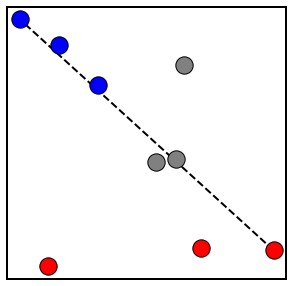

In [265]:
eb = 10
tp = +4
fig = plt.figure(figsize = [5,5])

## co-occurrence novelty
which = novelty_co_space_novelty_true
plt.scatter(which[0][[0,1,2],0,eb+tp], which[0][[0,1,2],2,eb+tp], marker = 'o', color = 'red', s = 300, edgecolor = 'k')
plt.scatter(which[0][[3,4,5],0,eb+tp], which[0][[3,4,5],2,eb+tp], marker = 'o', color = 'grey', s = 300, edgecolor = 'k')
plt.scatter(which[0][[6,7,8],0,eb+tp], which[0][[6,7,8],2,eb+tp], marker = 'o', color = 'blue', s = 300, edgecolor = 'k')

## valence novelty
# which = novelty_val_space_novelty_true
# plt.scatter(which[0][[0,3,6],0,eb+tp], which[0][[0,3,6],2,eb+tp], marker = 'o', color = 'magenta', s = 300, edgecolor = 'k')
# plt.scatter(which[0][[1,4,7],0,eb+tp], which[0][[1,4,7],2,eb+tp], marker = 'o', color = 'grey', s = 300, edgecolor = 'k')
# plt.scatter(which[0][[2,5,8],0,eb+tp], which[0][[2,5,8],2,eb+tp], marker = 'o', color = 'cyan', s = 300, edgecolor = 'k')

plt.xticks([])
plt.yticks([])
plt.plot([which[0][2,0,eb+tp], which[0][6,0,eb+tp]], [which[0][2,2,eb+tp], which[0][6,2,eb+tp]], color = 'k', zorder = 0, linewidth = 2, linestyle = '--')
# plt.savefig('/home/dasom/Dropbox/ubuntu-window/미팅자료/Neural_dynamics/Memory_novelty_cooccur_valence/Valence_space_valence_example.png', dpi=300, bbox_inches = "tight")

### Save beta martix and PC space with neural trajectory

In [ ]:
np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/beta_true_novelty.npy', beta_true_novelty)
np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/beta_perm_novelty.npy', beta_perm_novelty)
np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/beta_true_memory.npy', beta_true_memory)
np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/beta_perm_memory.npy', beta_perm_memory)
np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/beta_true_recall_start.npy', beta_true_recall)
np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/beta_perm_recall_start.npy', beta_perm_recall)

np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/novelty_co_space_novelty_true.npy', novelty_co_space_novelty_true)
np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/novelty_co_space_novelty_perm.npy', novelty_co_space_novelty_perm)
np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/novelty_val_space_novelty_true.npy', novelty_val_space_novelty_true)
np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/novelty_val_space_novelty_perm.npy', novelty_val_space_novelty_perm)

np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/novelty_co_space_memory_true.npy', novelty_co_space_memory_true)
np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/novelty_co_space_memory_perm.npy', novelty_co_space_memory_perm)
np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/novelty_val_space_memory_true.npy', novelty_val_space_memory_true)
np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/novelty_val_space_memory_perm.npy', novelty_val_space_memory_perm)

np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/memory_space_memory_true.npy', memory_space_memory_true)
np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/memory_space_memory_perm.npy', memory_space_memory_perm)
np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/memory_space_novelty_true.npy', memory_space_novelty_true)
np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/memory_space_novelty_perm.npy', memory_space_novelty_perm)

np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/retrieval_space_retrieval_true.npy', recall_start_space_recall_true)
np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/retrieval_space_retrieval_true.npy', recall_start_space_recall_perm)